In [97]:
import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import multiprocess as mp  # for kde multithreading calculation
from multiprocess import Pool

%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [98]:
depths = glob.glob("*k")
for depth in depths:
    if not os.path.exists(f"{depth}/cistopic_objects/"):
        os.mkdir(f"{depth}/cistopic_objects/")

In [99]:
fragments_list = sorted(
    glob.glob(f"*k/*_preprocessing_out/data/fragments/*fragments.tsv.gz")
)
fragments_dict = {}
for fragments_file in fragments_list:
    sample = fragments_file.split("/")[-1].split(".fragments.tsv.gz")[0]
    fragments_dict[sample] = fragments_file

fragments_dict

{'BIO_ddseq_1.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_1.10k.fragments.tsv.gz',
 'BIO_ddseq_2.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_2.10k.fragments.tsv.gz',
 'BIO_ddseq_3.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_3.10k.fragments.tsv.gz',
 'BIO_ddseq_4.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_4.10k.fragments.tsv.gz',
 'BRO_mtscatac_1.10k': '10k/10k_preprocessing_out/data/fragments/BRO_mtscatac_1.10k.fragments.tsv.gz',
 'BRO_mtscatac_2.10k': '10k/10k_preprocessing_out/data/fragments/BRO_mtscatac_2.10k.fragments.tsv.gz',
 'CNA_10xmultiome_1.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xmultiome_1.10k.fragments.tsv.gz',
 'CNA_10xmultiome_2.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xmultiome_2.10k.fragments.tsv.gz',
 'CNA_10xv11_1.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xv11_1.10k.fragments.tsv.gz',
 'CNA_10xv11_2.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xv11_2.10k.fragments

In [100]:
regions_paths_dict = {
    x.split("/")[-1].split(f"__")[0].replace(".FIXEDCELLS", ""): x
    for x in sorted(glob.glob("SCREEN_peaks/*consensus_peaks.bed"))
}
regions_paths_dict

{'BIO_ddseq_1': 'SCREEN_peaks/BIO_ddseq_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'BIO_ddseq_2': 'SCREEN_peaks/BIO_ddseq_2.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'BIO_ddseq_3': 'SCREEN_peaks/BIO_ddseq_3.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'BIO_ddseq_4': 'SCREEN_peaks/BIO_ddseq_4.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'BRO_mtscatac_1': 'SCREEN_peaks/BRO_mtscatac_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'BRO_mtscatac_2': 'SCREEN_peaks/BRO_mtscatac_2.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CNA_10xmultiome_1': 'SCREEN_peaks/CNA_10xmultiome_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CNA_10xmultiome_2': 'SCREEN_peaks/CNA_10xmultiome_2.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CNA_10xv11_1': 'SCREEN_peaks/CNA_10xv11_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CNA_10xv11_2': 'SCREEN_peaks/CNA_10xv11_2.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CNA_10xv11_3': 'SCREEN_peaks/CNA_10xv11_3.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CNA_10xv11_4': 'SCREEN_peaks/CNA_10xv11_4.F

In [101]:
regions_paths_dict["VIB_hydrop_11"] = regions_paths_dict["VIB_hydrop_1"]
regions_paths_dict["VIB_hydrop_12"] = regions_paths_dict["VIB_hydrop_1"]
regions_paths_dict["VIB_hydrop_21"] = regions_paths_dict["VIB_hydrop_2"]
regions_paths_dict["VIB_hydrop_22"] = regions_paths_dict["VIB_hydrop_2"]

In [102]:
regions_paths_dict = {x: regions_paths_dict[x.split(".")[0]] for x in fragments_dict}

In [103]:
metadata_bc_dict = {
    x.split("/")[-1].split(f"__")[0].replace(".FIXEDCELLS", ""): x
    for x in sorted(glob.glob("*k/cistopic_qc_out_CONSENSUS/*metadata*.pkl"))
}
metadata_bc_dict

{'BIO_ddseq_1.10k': '10k/cistopic_qc_out_CONSENSUS/BIO_ddseq_1.10k__metadata_bc.pkl',
 'BIO_ddseq_2.10k': '10k/cistopic_qc_out_CONSENSUS/BIO_ddseq_2.10k__metadata_bc.pkl',
 'BIO_ddseq_3.10k': '10k/cistopic_qc_out_CONSENSUS/BIO_ddseq_3.10k__metadata_bc.pkl',
 'BIO_ddseq_4.10k': '10k/cistopic_qc_out_CONSENSUS/BIO_ddseq_4.10k__metadata_bc.pkl',
 'BRO_mtscatac_1.10k': '10k/cistopic_qc_out_CONSENSUS/BRO_mtscatac_1.10k__metadata_bc.pkl',
 'BRO_mtscatac_2.10k': '10k/cistopic_qc_out_CONSENSUS/BRO_mtscatac_2.10k__metadata_bc.pkl',
 'CNA_10xmultiome_1.10k': '10k/cistopic_qc_out_CONSENSUS/CNA_10xmultiome_1.10k__metadata_bc.pkl',
 'CNA_10xmultiome_2.10k': '10k/cistopic_qc_out_CONSENSUS/CNA_10xmultiome_2.10k__metadata_bc.pkl',
 'CNA_10xv11_1.10k': '10k/cistopic_qc_out_CONSENSUS/CNA_10xv11_1.10k__metadata_bc.pkl',
 'CNA_10xv11_2.10k': '10k/cistopic_qc_out_CONSENSUS/CNA_10xv11_2.10k__metadata_bc.pkl',
 'CNA_10xv11_3.10k': '10k/cistopic_qc_out_CONSENSUS/CNA_10xv11_3.10k__metadata_bc.pkl',
 'CNA_10xv11

In [104]:
bc_passing_filters_dict = {
    x.split("/")[-1].split(f".")[0].replace(".FIXEDCELLS", ""): x
    for x in sorted(glob.glob("selected_barcodes/*.pkl"))
}
bc_passing_filters_dict

{'BIO_ddseq_1': 'selected_barcodes/BIO_ddseq_1.FULL_bc_passing_filters_otsu.pkl',
 'BIO_ddseq_2': 'selected_barcodes/BIO_ddseq_2.FULL_bc_passing_filters_otsu.pkl',
 'BIO_ddseq_3': 'selected_barcodes/BIO_ddseq_3.FULL_bc_passing_filters_otsu.pkl',
 'BIO_ddseq_4': 'selected_barcodes/BIO_ddseq_4.FULL_bc_passing_filters_otsu.pkl',
 'BRO_mtscatac_1': 'selected_barcodes/BRO_mtscatac_1.FULL_bc_passing_filters_otsu.pkl',
 'BRO_mtscatac_2': 'selected_barcodes/BRO_mtscatac_2.FULL_bc_passing_filters_otsu.pkl',
 'CNA_10xmultiome_1': 'selected_barcodes/CNA_10xmultiome_1.FULL_bc_passing_filters_otsu.pkl',
 'CNA_10xmultiome_2': 'selected_barcodes/CNA_10xmultiome_2.FULL_bc_passing_filters_otsu.pkl',
 'CNA_10xv11_1': 'selected_barcodes/CNA_10xv11_1.FULL_bc_passing_filters_otsu.pkl',
 'CNA_10xv11_2': 'selected_barcodes/CNA_10xv11_2.FULL_bc_passing_filters_otsu.pkl',
 'CNA_10xv11_3': 'selected_barcodes/CNA_10xv11_3.FULL_bc_passing_filters_otsu.pkl',
 'CNA_10xv11_4': 'selected_barcodes/CNA_10xv11_4.FULL_bc

Now, make a sub dictionary of all samples within the fragments dict that have not been run yet (good for resuming a stopped cistopic run):

In [105]:
path_to_blacklist = "../0_resources/regions/hg38-blacklist.v2.bed"

In [106]:
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import ray

ray.shutdown()

In [107]:
if regions_paths_dict != {}:
    n_cores = 16
    for sample in metadata_bc_dict.keys():
        print(sample)
        mastersample = sample.split(".")[0]
        print(mastersample)
        cto_path = metadata_bc_dict[sample].replace(
            f"cistopic_qc_out_CONSENSUS/{sample}__metadata_bc.pkl",
            f"cistopic_objects/{sample}__cto.pkl",
        )
        if not os.path.exists(cto_path):
            print(f"{cto_path} does not exist, generating...")

            infile = open(metadata_bc_dict[sample], "rb")
            metadata_bc = pickle.load(infile)
            metadata_bc.index = [bc.split("___")[0] for bc in metadata_bc.index]
            infile.close()

            infile = open(bc_passing_filters_dict[mastersample], "rb")
            bc_passing_filters = pickle.load(infile)
            infile.close()
            bc_passing_filters_fixed = [bc.split("___")[0] for bc in bc_passing_filters]

            cto = create_cistopic_object_from_fragments(
                path_to_fragments=fragments_dict[sample],
                path_to_regions=regions_paths_dict[sample],
                path_to_blacklist=path_to_blacklist,
                metrics=metadata_bc,
                valid_bc=bc_passing_filters_fixed,
                n_cpu=n_cores,
                partition=10,
                project=sample,
            )

            print(f"Writing {sample} cto in {cto_path}...")

            with open(cto_path, "wb") as f:
                pickle.dump(cto, f, protocol=4)
        else:
            print(f"{cto_path} already exists, skipping...")

else:
    print("All samples already processed.")

BIO_ddseq_1.10k
BIO_ddseq_1
10k/cistopic_objects/BIO_ddseq_1.10k__cto.pkl already exists, skipping...
BIO_ddseq_2.10k
BIO_ddseq_2
10k/cistopic_objects/BIO_ddseq_2.10k__cto.pkl already exists, skipping...
BIO_ddseq_3.10k
BIO_ddseq_3
10k/cistopic_objects/BIO_ddseq_3.10k__cto.pkl already exists, skipping...
BIO_ddseq_4.10k
BIO_ddseq_4
10k/cistopic_objects/BIO_ddseq_4.10k__cto.pkl already exists, skipping...
BRO_mtscatac_1.10k
BRO_mtscatac_1
10k/cistopic_objects/BRO_mtscatac_1.10k__cto.pkl already exists, skipping...
BRO_mtscatac_2.10k
BRO_mtscatac_2
10k/cistopic_objects/BRO_mtscatac_2.10k__cto.pkl already exists, skipping...
CNA_10xmultiome_1.10k
CNA_10xmultiome_1
10k/cistopic_objects/CNA_10xmultiome_1.10k__cto.pkl already exists, skipping...
CNA_10xmultiome_2.10k
CNA_10xmultiome_2
10k/cistopic_objects/CNA_10xmultiome_2.10k__cto.pkl already exists, skipping...
CNA_10xv11_1.10k
CNA_10xv11_1
10k/cistopic_objects/CNA_10xv11_1.10k__cto.pkl already exists, skipping...
CNA_10xv11_2.10k
CNA_10xv

# write looms

In [108]:
depths = glob.glob("*k")
for depth in depths:
    if not os.path.exists(f"{depth}/cell_region_looms/"):
        os.mkdir(f"{depth}/cell_region_looms/")

In [109]:
cto_dict = {
    x.split("/")[-1].split(f"__")[0]: x
    for x in sorted(glob.glob(f"*k/cistopic_objects/VIB_hydrop*__cto.pkl"))
}
cto_dict

{'VIB_hydrop_1.10k': '10k/cistopic_objects/VIB_hydrop_1.10k__cto.pkl',
 'VIB_hydrop_2.10k': '10k/cistopic_objects/VIB_hydrop_2.10k__cto.pkl',
 'VIB_hydrop_1.15k': '15k/cistopic_objects/VIB_hydrop_1.15k__cto.pkl',
 'VIB_hydrop_2.15k': '15k/cistopic_objects/VIB_hydrop_2.15k__cto.pkl',
 'VIB_hydrop_1.20k': '20k/cistopic_objects/VIB_hydrop_1.20k__cto.pkl',
 'VIB_hydrop_2.20k': '20k/cistopic_objects/VIB_hydrop_2.20k__cto.pkl',
 'VIB_hydrop_1.25k': '25k/cistopic_objects/VIB_hydrop_1.25k__cto.pkl',
 'VIB_hydrop_2.25k': '25k/cistopic_objects/VIB_hydrop_2.25k__cto.pkl',
 'VIB_hydrop_1.30k': '30k/cistopic_objects/VIB_hydrop_1.30k__cto.pkl',
 'VIB_hydrop_2.30k': '30k/cistopic_objects/VIB_hydrop_2.30k__cto.pkl',
 'VIB_hydrop_1.35k': '35k/cistopic_objects/VIB_hydrop_1.35k__cto.pkl',
 'VIB_hydrop_2.35k': '35k/cistopic_objects/VIB_hydrop_2.35k__cto.pkl',
 'VIB_hydrop_1.5k': '5k/cistopic_objects/VIB_hydrop_1.5k__cto.pkl',
 'VIB_hydrop_2.5k': '5k/cistopic_objects/VIB_hydrop_2.5k__cto.pkl'}

In [110]:
cto_path_sub_dict = {}
for sample in cto_dict.keys():
    cto_path = cto_dict[sample]
    loom_path = os.path.join(
        cto_path.split("/")[-1]
        .replace("cistopic_objects", "cell_region_looms")
        .replace(".pkl", ".loom")
    )
    print(f"Checking if {loom_path} exist...")
    if os.path.exists(loom_path):
        print(f"\t{loom_path} exists! Skipping...")
    else:
        print(f"\t{loom_path} does not exist, adding to subdict to generate")
        cto_path_sub_dict[sample] = cto_dict[sample]

Checking if VIB_hydrop_1.10k__cto.loom exist...
	VIB_hydrop_1.10k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_2.10k__cto.loom exist...
	VIB_hydrop_2.10k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_1.15k__cto.loom exist...
	VIB_hydrop_1.15k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_2.15k__cto.loom exist...
	VIB_hydrop_2.15k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_1.20k__cto.loom exist...
	VIB_hydrop_1.20k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_2.20k__cto.loom exist...
	VIB_hydrop_2.20k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_1.25k__cto.loom exist...
	VIB_hydrop_1.25k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_2.25k__cto.loom exist...
	VIB_hydrop_2.25k__cto.loom does not exist, adding to subdict to generate
Checking if VIB_hydrop_1

In [111]:
barcodes_path_dict = {
    x.split("/")[-1].split(f".")[0]: x
    for x in sorted(glob.glob(f"selected_barcodes_singlets/*tsv"))
}
barcodes_path_dict

{'BIO_ddseq_1': 'selected_barcodes_singlets/BIO_ddseq_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_11topics.dimreduc.consensus_barcodes.tsv',
 'BIO_ddseq_2': 'selected_barcodes_singlets/BIO_ddseq_2.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_14topics.dimreduc.consensus_barcodes.tsv',
 'BIO_ddseq_3': 'selected_barcodes_singlets/BIO_ddseq_3.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_10topics.dimreduc.consensus_barcodes.tsv',
 'BIO_ddseq_4': 'selected_barcodes_singlets/BIO_ddseq_4.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_11topics.dimreduc.consensus_barcodes.tsv',
 'BRO_mtscatac_1': 'selected_barcodes_singlets/BRO_mtscatac_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_11topics.dimreduc.consensus_barcodes.tsv',
 'BRO_mtscatac_2': 'selected_barcodes_singlets/BRO_mtscatac_2.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_17topics.dimreduc.consensus_barcodes.tsv',
 'CNA_10xmultiome_1': 'selected_barcodes_singlets/CNA_10xmultiome_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.mod

In [112]:
import loompy as lp

In [115]:
for sample in cto_path_sub_dict.keys():
    depth = sample.split(".")[-1]
    cto_path = cto_path_sub_dict[sample]
    with open(cto_path, "rb") as f:
        cto = pickle.load(f)
    print(cto.cell_names[0])
    print(len(cto.cell_names))

    supersample = sample.split(".")[0]
    selected_barcodes = pd.read_csv(barcodes_path_dict[supersample], header=None)
    print(len(selected_barcodes))

    print(selected_barcodes[0][0])
    selected_barcodes_fixed = [
        x.replace("___VIB_hydrop_11.FIXEDCELLS", f"-1___VIB_hydrop_1.{depth}")
        .replace("___VIB_hydrop_12.FIXEDCELLS", f"-2___VIB_hydrop_1.{depth}")
        .replace("___VIB_hydrop_21.FIXEDCELLS", f"-1___VIB_hydrop_2.{depth}")
        .replace("___VIB_hydrop_22.FIXEDCELLS", f"-2___VIB_hydrop_2.{depth}")
        for x in selected_barcodes[0]
    ]
    print(selected_barcodes_fixed[0])

    cto.subset(selected_barcodes_fixed)
    print(cto.cell_names[0])

    selected_barcodes_fixed2 = [
        x.replace(f"-1___VIB_hydrop_1.{depth}", "-1")
        .replace(f"-2___VIB_hydrop_1.{depth}", "-2")
        .replace(f"-1___VIB_hydrop_2.{depth}", "-1")
        .replace(f"-2___VIB_hydrop_2.{depth}", "-2")
        for x in cto.cell_names
    ]
    cto.cell_names = selected_barcodes_fixed2
    print(cto.cell_names[0])

    print(f"Loaded filtered cistopic object {sample}")
    loom_path = cto_path.replace("cistopic_objects", "cell_region_looms").replace(
        "__cto.pkl", "__cto.loom"
    )
    lp.create(
        filename=loom_path,
        layers=cto.fragment_matrix,
        row_attrs={"Gene": cto.region_names},
        col_attrs={"CellID": cto.cell_names},
    )
    print(f"Finished {loom_path} loom writing")

CGTGAATGAAGCCTTCTCTC-2___VIB_hydrop_1.10k
2524
2408
CCTCCATAAGTTGCAGTTCT___VIB_hydrop_11.FIXEDCELLS
CCTCCATAAGTTGCAGTTCT-1___VIB_hydrop_1.10k
CCTCCATAAGTTGCAGTTCT-1___VIB_hydrop_1.10k
CCTCCATAAGTTGCAGTTCT-1
Loaded filtered cistopic object VIB_hydrop_1.10k
Finished 10k/cell_region_looms/VIB_hydrop_1.10k__cto.loom loom writing
TGAAGTGAGCTTCGCACAAC-1___VIB_hydrop_2.10k
3042
2949
TGAAGTGAGCCCTTAGGCGA___VIB_hydrop_21.FIXEDCELLS
TGAAGTGAGCCCTTAGGCGA-1___VIB_hydrop_2.10k
TGAAGTGAGCCCTTAGGCGA-1___VIB_hydrop_2.10k
TGAAGTGAGCCCTTAGGCGA-1
Loaded filtered cistopic object VIB_hydrop_2.10k
Finished 10k/cell_region_looms/VIB_hydrop_2.10k__cto.loom loom writing
CGTGAATGAAGCCTTCTCTC-2___VIB_hydrop_1.15k
2524
2408
CCTCCATAAGTTGCAGTTCT___VIB_hydrop_11.FIXEDCELLS
CCTCCATAAGTTGCAGTTCT-1___VIB_hydrop_1.15k
CCTCCATAAGTTGCAGTTCT-1___VIB_hydrop_1.15k
CCTCCATAAGTTGCAGTTCT-1
Loaded filtered cistopic object VIB_hydrop_1.15k
Finished 15k/cell_region_looms/VIB_hydrop_1.15k__cto.loom loom writing
TGAAGTGAGCTTCGCACAA

# run seurat

In [116]:
frags_path_dict = {
    x.split("/")[-1].split(f".fragments.tsv.gz")[0]: x
    for x in sorted(
        glob.glob(f"*k/*k_preprocessing_out/data/fragments/*fragments.tsv.gz")
    )
}
frags_path_dict

{'BIO_ddseq_1.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_1.10k.fragments.tsv.gz',
 'BIO_ddseq_2.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_2.10k.fragments.tsv.gz',
 'BIO_ddseq_3.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_3.10k.fragments.tsv.gz',
 'BIO_ddseq_4.10k': '10k/10k_preprocessing_out/data/fragments/BIO_ddseq_4.10k.fragments.tsv.gz',
 'BRO_mtscatac_1.10k': '10k/10k_preprocessing_out/data/fragments/BRO_mtscatac_1.10k.fragments.tsv.gz',
 'BRO_mtscatac_2.10k': '10k/10k_preprocessing_out/data/fragments/BRO_mtscatac_2.10k.fragments.tsv.gz',
 'CNA_10xmultiome_1.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xmultiome_1.10k.fragments.tsv.gz',
 'CNA_10xmultiome_2.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xmultiome_2.10k.fragments.tsv.gz',
 'CNA_10xv11_1.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xv11_1.10k.fragments.tsv.gz',
 'CNA_10xv11_2.10k': '10k/10k_preprocessing_out/data/fragments/CNA_10xv11_2.10k.fragments

In [117]:
scrub_name_suffix = "0-4"
loom_path_dict = {
    x.split("/")[-1].split(f"__")[0]: x
    for x in sorted(glob.glob(f"*k/cell_region_looms/*.loom"))
}
loom_path_dict

{'BIO_ddseq_1.10k': '10k/cell_region_looms/BIO_ddseq_1.10k__cto.loom',
 'BIO_ddseq_2.10k': '10k/cell_region_looms/BIO_ddseq_2.10k__cto.loom',
 'BIO_ddseq_3.10k': '10k/cell_region_looms/BIO_ddseq_3.10k__cto.loom',
 'BIO_ddseq_4.10k': '10k/cell_region_looms/BIO_ddseq_4.10k__cto.loom',
 'BRO_mtscatac_1.10k': '10k/cell_region_looms/BRO_mtscatac_1.10k__cto.loom',
 'BRO_mtscatac_2.10k': '10k/cell_region_looms/BRO_mtscatac_2.10k__cto.loom',
 'CNA_10xmultiome_1.10k': '10k/cell_region_looms/CNA_10xmultiome_1.10k__cto.loom',
 'CNA_10xmultiome_2.10k': '10k/cell_region_looms/CNA_10xmultiome_2.10k__cto.loom',
 'CNA_10xv11_1.10k': '10k/cell_region_looms/CNA_10xv11_1.10k__cto.loom',
 'CNA_10xv11_2.10k': '10k/cell_region_looms/CNA_10xv11_2.10k__cto.loom',
 'CNA_10xv11_3.10k': '10k/cell_region_looms/CNA_10xv11_3.10k__cto.loom',
 'CNA_10xv11_4.10k': '10k/cell_region_looms/CNA_10xv11_4.10k__cto.loom',
 'CNA_10xv11_5.10k': '10k/cell_region_looms/CNA_10xv11_5.10k__cto.loom',
 'CNA_10xv2_1.10k': '10k/cell_r

In [118]:
depths = glob.glob("*k")
for depth in depths:
    if not os.path.exists(f"{depth}/cell_type_classification/"):
        os.mkdir(f"{depth}/cell_type_classification/")

In [119]:
parallel_filename = "seurat_label_transfer.parallel"
script_path = "../0_resources/scripts/seurat_label_transfer_consensus.R"
img_path = "../0_resources/vsn_cache/cflerin-seurat-4.0.3-plus.sif"
reference_path = "../0_resources/seurat_references/pbmc_ref.rds"
annotation_path = "../0_resources/seurat_references/granges_annotation.rds"
bind_mounts = "/dodrio,/readonly/dodrio,/tmp"
# bind_mounts = "/lustre1,/staging,${VSC_SCRATCH}/tmp:/tmp"

with open(parallel_filename, "w") as f:
    for sample in loom_path_dict.keys():
        loomfile = loom_path_dict[sample]
        outfile = loomfile.replace(
            "cell_region_looms", "cell_type_classification"
        ).replace("__cto.loom", "__cell_type_seurat.txt")
        if not os.path.exists(outfile):
            fragfile = frags_path_dict[sample]
            command = f"Rscript {script_path} {sample} {loomfile} {fragfile} {reference_path} {annotation_path} {outfile}"
            f.write(f"{command}\n")
            print(command)

        else:
            # f.write(f"#{outfile} already exists!\n")
            print(f"#{outfile} already exists!")

#10k/cell_type_classification/BIO_ddseq_1.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/BIO_ddseq_2.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/BIO_ddseq_3.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/BIO_ddseq_4.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/BRO_mtscatac_1.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/BRO_mtscatac_2.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/CNA_10xmultiome_1.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/CNA_10xmultiome_2.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/CNA_10xv11_1.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/CNA_10xv11_2.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/CNA_10xv11_3.10k__cell_type_seurat.txt already exists!
#10k/cell_type_classification/CNA_10xv11_4.10k__cell_ty

# Run the Rscript

```
export OMP_THREAD_LIMIT=10
cat seurat_label_transfer.parallel.aa | parallel -j 16 --progress
```

In [120]:
kill $(jobs -p)

SyntaxError: invalid syntax (4107442686.py, line 1)

2022-09-22 12:23:51,642 root         ERROR    Cannot parse: 1:4: kill $(jobs -p)
Traceback (most recent call last):
  File "/opt/venv/lib/python3.8/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/opt/venv/lib/python3.8/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "src/black/__init__.py", line 1163, in format_str
  File "src/black/__init__.py", line 1173, in _format_str_once
  File "src/black/parsing.py", line 128, in lib2to3_parse
black.parsing.InvalidInput: Cannot parse: 1:4: kill $(jobs -p)


# analyse

In [121]:
seur_path_dict = {
    x.split("/")[-1].split(f"__")[0]: x
    for x in sorted(glob.glob(f"*k/cell_type_classification/*"))
}
seur_path_dict

{'BIO_ddseq_1.10k': '10k/cell_type_classification/BIO_ddseq_1.10k__cell_type_seurat.txt',
 'BIO_ddseq_2.10k': '10k/cell_type_classification/BIO_ddseq_2.10k__cell_type_seurat.txt',
 'BIO_ddseq_3.10k': '10k/cell_type_classification/BIO_ddseq_3.10k__cell_type_seurat.txt',
 'BIO_ddseq_4.10k': '10k/cell_type_classification/BIO_ddseq_4.10k__cell_type_seurat.txt',
 'BRO_mtscatac_1.10k': '10k/cell_type_classification/BRO_mtscatac_1.10k__cell_type_seurat.txt',
 'BRO_mtscatac_2.10k': '10k/cell_type_classification/BRO_mtscatac_2.10k__cell_type_seurat.txt',
 'CNA_10xmultiome_1.10k': '10k/cell_type_classification/CNA_10xmultiome_1.10k__cell_type_seurat.txt',
 'CNA_10xmultiome_2.10k': '10k/cell_type_classification/CNA_10xmultiome_2.10k__cell_type_seurat.txt',
 'CNA_10xv11_1.10k': '10k/cell_type_classification/CNA_10xv11_1.10k__cell_type_seurat.txt',
 'CNA_10xv11_2.10k': '10k/cell_type_classification/CNA_10xv11_2.10k__cell_type_seurat.txt',
 'CNA_10xv11_3.10k': '10k/cell_type_classification/CNA_10xv1

In [122]:
df_seur_merged = pd.DataFrame()
for sample in seur_path_dict.keys():
    df_seur = pd.read_csv(seur_path_dict[sample], sep="\t", index_col=0)
    df_seur_merged = pd.concat([df_seur_merged, df_seur])

In [123]:
df_seur

,barcode,sample_id,cell_type,cell_type_pred_score,cell_type_hiconf_70
composite_sample_id,,,,,
TGAAGTGAGCCCTTAGGCGA-1-VIB_hydrop_2.5k,TGAAGTGAGCCCTTAGGCGA-1,VIB_hydrop_2.5k,CD4+ T cell,0.632627,Unknown
TGAAGTGAGCTTCGCACAAC-1-VIB_hydrop_2.5k,TGAAGTGAGCTTCGCACAAC-1,VIB_hydrop_2.5k,Cytotoxic T cell,0.410080,Unknown
AACCACGGATCTGGAGTTGA-1-VIB_hydrop_2.5k,AACCACGGATCTGGAGTTGA-1,VIB_hydrop_2.5k,CD16+ monocyte,0.745953,CD16+ monocyte
AGGCTTGCCTGTCGACTAAC-1-VIB_hydrop_2.5k,AGGCTTGCCTGTCGACTAAC-1,VIB_hydrop_2.5k,CD14+ monocyte,0.486457,Unknown
CAATTGGAGATGACACACCT-1-VIB_hydrop_2.5k,CAATTGGAGATGACACACCT-1,VIB_hydrop_2.5k,Cytotoxic T cell,0.291496,Unknown
...,...,...,...,...,...
GACGAGGTAAGATGGCCAAC-2-VIB_hydrop_2.5k,GACGAGGTAAGATGGCCAAC-2,VIB_hydrop_2.5k,Cytotoxic T cell,0.367369,Unknown
AGGTTGCATTATCCGAGTAT-2-VIB_hydrop_2.5k,AGGTTGCATTATCCGAGTAT-2,VIB_hydrop_2.5k,Cytotoxic T cell,0.588569,Unknown
TCAAGAGGCGAGGACGTTCG-2-VIB_hydrop_2.5k,TCAAGAGGCGAGGACGTTCG-2,VIB_hydrop_2.5k,Cytotoxic T cell,0.833194,Cytotoxic T cell


In [124]:
len(df_seur_merged)

1184082

In [125]:
df_seur_merged["depth"] = [
    int(x.split(".")[-1].replace("k", "")) for x in df_seur_merged["sample_id"]
]

In [126]:
df_seur_merged["tech"] = [x.split("_")[1] for x in df_seur_merged["sample_id"]]

In [127]:
df_seur_merged["supersample"] = [x.split(".")[0] for x in df_seur_merged["sample_id"]]

In [128]:
table = pd.pivot_table(
    df_seur_merged,
    values="cell_type_pred_score",
    index=["supersample", "depth"],
    aggfunc=np.median,
)

In [129]:
table

cell_type_pred_score
supersample  depth                      
BIO_ddseq_1  5                  0.526750
             10                 0.575052
             15                 0.648881
             20                 0.640342
             25                 0.670347
...                                  ...
VIB_hydrop_2 15                 0.549370
             20                 0.547465
             25                 0.569485
             30                 0.558793
             35                 0.623807

[329 rows x 1 columns]

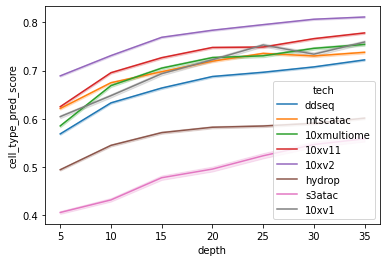

In [130]:
sns.lineplot(x="depth", y="cell_type_pred_score", hue="tech", data=df_seur_merged)
plt.savefig("plts/test.png", facecolor="w", dpi=300)